In [1]:
# Navigate to the content directory in Colab
%cd /content

# Clone the specific branch of ComfyUI from GitHub
!git clone -b totoro3 https://github.com/camenduru/ComfyUI /content/TotoroUI

# Navigate to the cloned directory
%cd /content/TotoroUI

# Install necessary Python packages quietly
!pip install -q torchsde einops diffusers accelerate xformers==0.0.27.post2

# Install aria2 package for downloading multiple files concurrently
!apt -y install -qq aria2

# Download required model files using aria2 with concurrency
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/flux1-dev-fp8.safetensors -d /content/TotoroUI/models/unet -o flux1-dev-fp8.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/ae.sft -d /content/TotoroUI/models/vae -o ae.sft
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/clip_l.safetensors -d /content/TotoroUI/models/clip -o clip_l.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/t5xxl_fp8_e4m3fn.safetensors -d /content/TotoroUI/models/clip -o t5xxl_fp8_e4m3fn.safetensors


[Errno 2] No such file or directory: '/content'
/root
Cloning into '/content/TotoroUI'...


/root/miniconda3/envs/FLUX.1/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


remote: Enumerating objects: 14652, done.
remote: Counting objects: 100% (3345/3345), done.
remote: Compressing objects: 100% (324/324), done.
remote: Total 14652 (delta 3151), reused 3042 (delta 3021), pack-reused 11307 (from 1)
Receiving objects: 100% (14652/14652), 23.05 MiB | 19.74 MiB/s, done.
Resolving deltas: 100% (9846/9846), done.
/content/TotoroUI


/root/miniconda3/envs/FLUX.1/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


The following additional packages will be installed:
  libaria2-0 libc-ares2 libssh2-1
The following NEW packages will be installed:
  aria2 libaria2-0 libc-ares2 libssh2-1
0 upgraded, 4 newly installed, 0 to remove and 13 not upgraded.
Need to get 1622 kB of archives.
After this operation, 5817 kB of additional disk space will be used.

78Selecting previously unselected package libc-ares2:amd64.
(Reading database ... 94125 files and directories currently installed.)
Preparing to unpack .../libc-ares2_1.18.1-1ubuntu0.22.04.3_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [  6%] [###.......................................................] 8Unpacking libc-ares2:amd64 (1.18.1-1ubuntu0.22.04.3) ...
7Progress: [ 12%] [######....................................................] 8Selecting previously unselected package libssh2-1:amd64.
Preparing to unpack .../libssh2-1_1.10.0-3_amd64.deb ...
7Progress: [ 18%] [##########......

In [4]:
import random
import torch
import numpy as np
from PIL import Image
import nodes
from nodes import NODE_CLASS_MAPPINGS
from totoro_extras import nodes_custom_sampler
from totoro import model_management
from IPython.display import display

In [5]:
# Initialize the loaders using the model mappings
DualCLIPLoader = NODE_CLASS_MAPPINGS["DualCLIPLoader"]()
UNETLoader = NODE_CLASS_MAPPINGS["UNETLoader"]()
RandomNoise = nodes_custom_sampler.NODE_CLASS_MAPPINGS["RandomNoise"]()
BasicGuider = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicGuider"]()
KSamplerSelect = nodes_custom_sampler.NODE_CLASS_MAPPINGS["KSamplerSelect"]()
BasicScheduler = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicScheduler"]()
SamplerCustomAdvanced = nodes_custom_sampler.NODE_CLASS_MAPPINGS["SamplerCustomAdvanced"]()
VAELoader = NODE_CLASS_MAPPINGS["VAELoader"]()
VAEDecode = NODE_CLASS_MAPPINGS["VAEDecode"]()
EmptyLatentImage = NODE_CLASS_MAPPINGS["EmptyLatentImage"]()


with torch.inference_mode():
    clip = DualCLIPLoader.load_clip("t5xxl_fp8_e4m3fn.safetensors", "clip_l.safetensors", "flux")[0]
    unet = UNETLoader.load_unet("flux1-dev-fp8.safetensors", "fp8_e4m3fn")[0]
    vae = VAELoader.load_vae("ae.sft")[0]

# Define your closestNumber function
def closestNumber(n, m):
    q = int(n / m)
    n1 = m * q
    if (n * m) > 0:
        n2 = m * (q + 1)
    else:
        n2 = m * (q - 1)
    if abs(n - n1) < abs(n - n2):
        return n1
    return n2

clip missing: ['text_projection.weight']
model_type FLUX
Using xformers attention in VAE
Using xformers attention in VAE


In [6]:
def generate_image(positive_prompt, width=1024, height=1024, seed=0, steps=20, sampler_name="euler", scheduler="simple"):
    with torch.inference_mode():
        if seed == 0:
            seed = random.randint(0, 18446744073709551615)
        print(f"Using seed: {seed}")

        # Encode the positive prompt
        cond, pooled = clip.encode_from_tokens(clip.tokenize(positive_prompt), return_pooled=True)
        cond = [[cond, {"pooled_output": pooled}]]

        # Generate noise and guider
        noise = RandomNoise.get_noise(seed)[0]
        guider = BasicGuider.get_guider(unet, cond)[0]

        # Select sampler and get sigmas
        sampler = KSamplerSelect.get_sampler(sampler_name)[0]
        sigmas = BasicScheduler.get_sigmas(unet, scheduler, steps, 1.0)[0]

        # Generate latent image
        latent_image = EmptyLatentImage.generate(closestNumber(width, 16), closestNumber(height, 16))[0]

        # Perform sampling
        sample, sample_denoised = SamplerCustomAdvanced.sample(noise, guider, sampler, sigmas, latent_image)

        # Clear cache
        model_management.soft_empty_cache()

        # Decode the sampled image and save it
        decoded = VAEDecode.decode(vae, sample)[0].detach()
        decoded = VAEDecode.decode(vae, sample)[0].detach()
        Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0]).save("/content/flux.png")

        img = Image.fromarray(np.array(decoded * 255, dtype=np.uint8)[0])
        img.save("/content/flux.png")
        return img

Requested to load FluxClipModel_
Loading 1 new model


Using seed: 9864619652524576360


Requested to load Flux
Loading 1 new model


  0%|          | 0/20 [00:00<?, ?it/s]

Requested to load AutoencodingEngine
Loading 1 new model
/tmp/ipykernel_24752/1013537319.py:31: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0]).save("/content/flux.png")
/tmp/ipykernel_24752/1013537319.py:33: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  img = Image.fromarray(np.array(decoded * 255, dtype=np.uint8)[0])


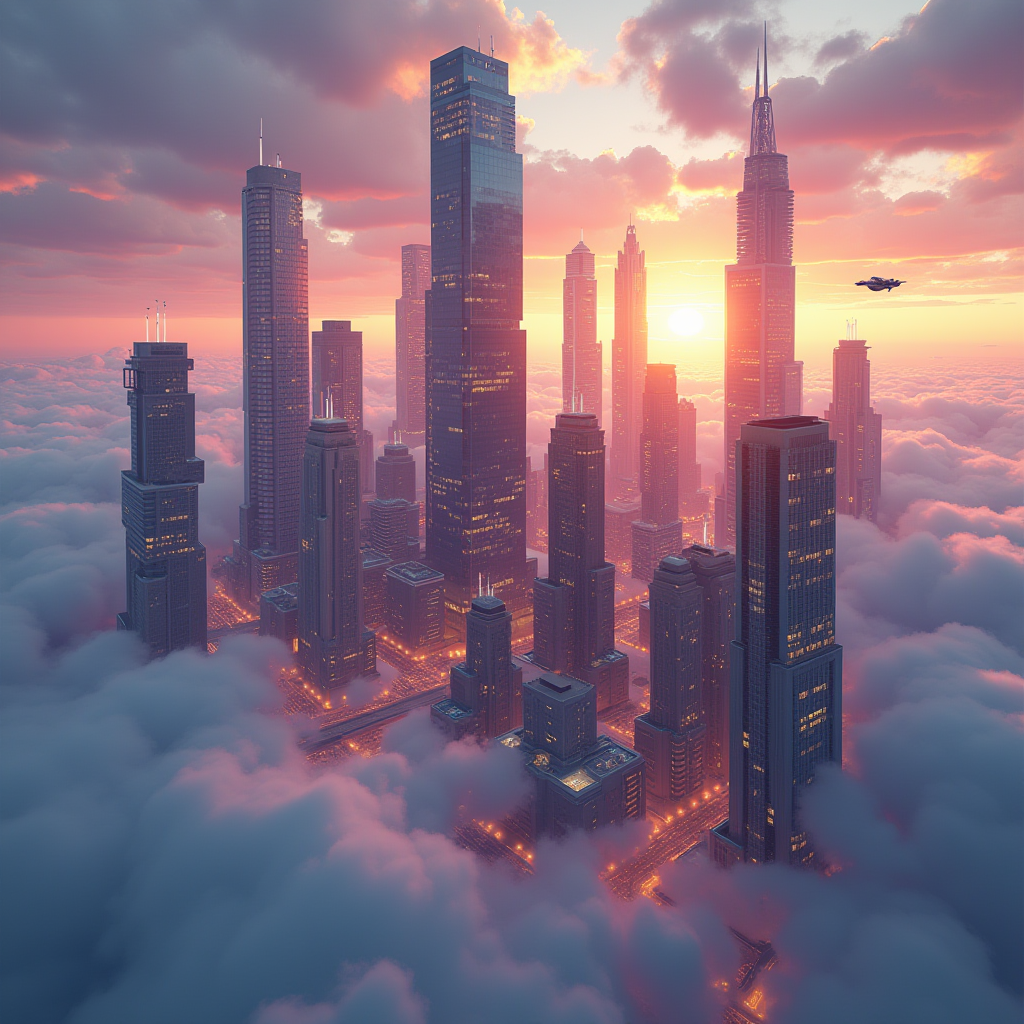

In [7]:
# Usage example:
positive_prompt = "A futuristic city floating above the clouds, with towering glass skyscrapers reflecting the colors of a vibrant sunset, flying cars zipping between the buildings, and a glowing neon skyline."
image = generate_image(positive_prompt)
display(image)

Using seed: 13561279963495133200


  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipykernel_24752/1013537319.py:31: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0]).save("/content/flux.png")
/tmp/ipykernel_24752/1013537319.py:33: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  img = Image.fromarray(np.array(decoded * 255, dtype=np.uint8)[0])


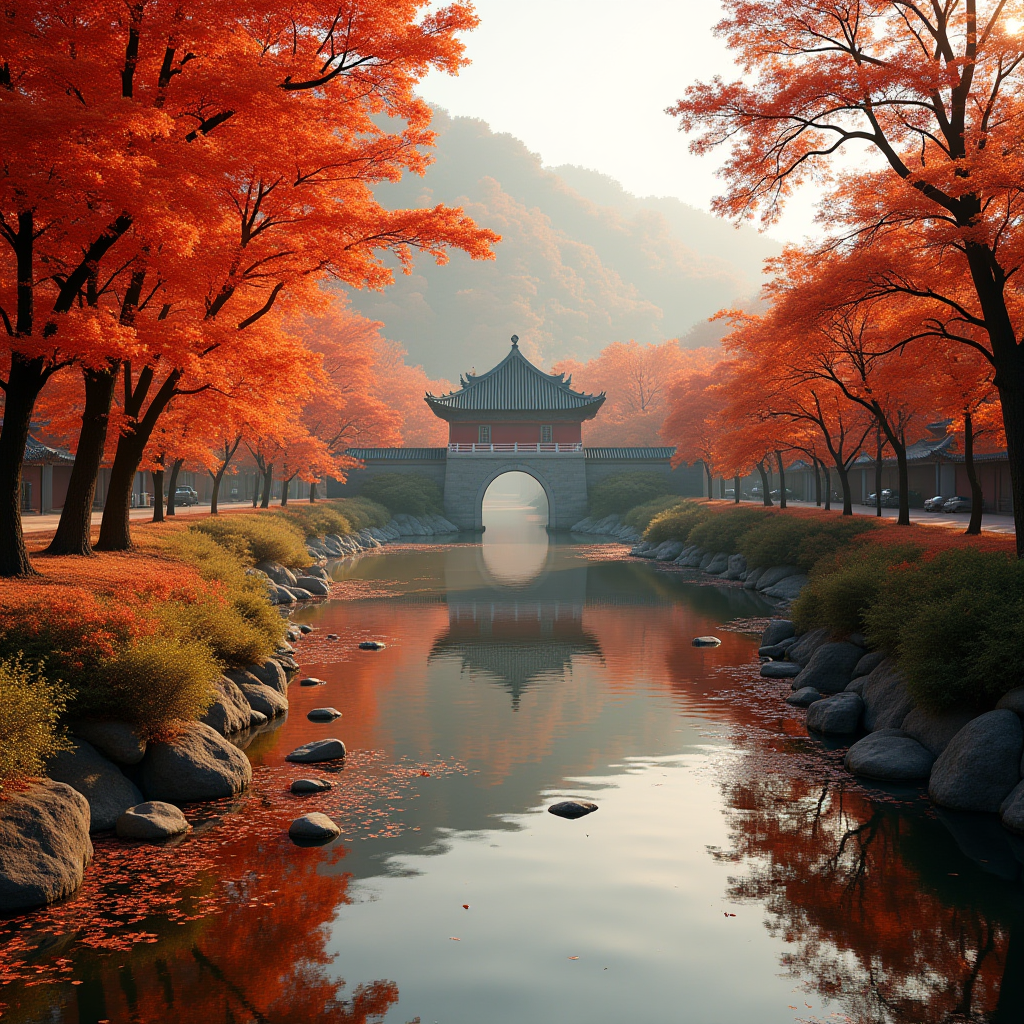

In [44]:
# Example of how to call the function
image = generate_image("The most beautiful October in Beijing")
display(image)

Using seed: 17511855609511395474


  0%|          | 0/20 [00:00<?, ?it/s]

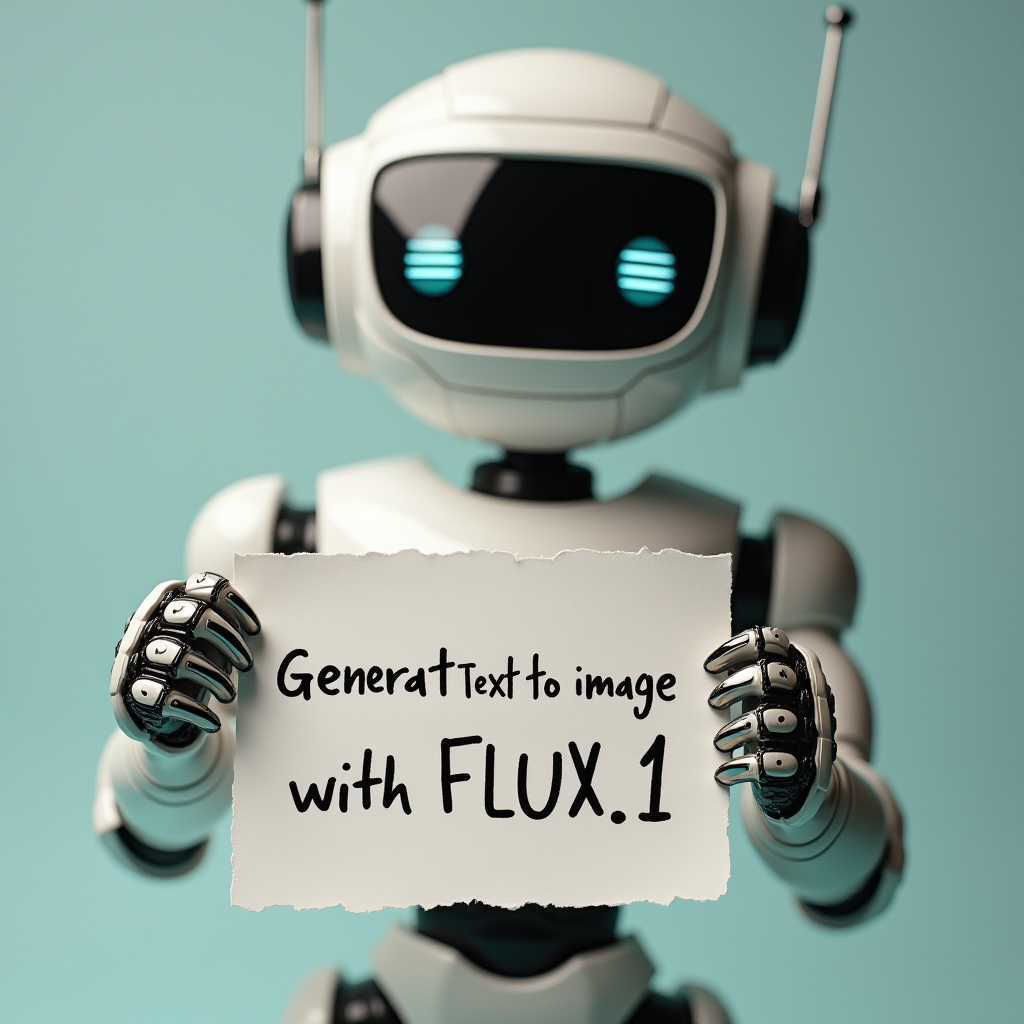

In [14]:
# Example of how to call the function
image = generate_image("A robot is holding a piece of paper that reads 'Generate text to image with FLUX.1'.")
display(image)

Using seed: 13747490171212170945


  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipykernel_24752/1013537319.py:31: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0]).save("/content/flux.png")
/tmp/ipykernel_24752/1013537319.py:33: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  img = Image.fromarray(np.array(decoded * 255, dtype=np.uint8)[0])


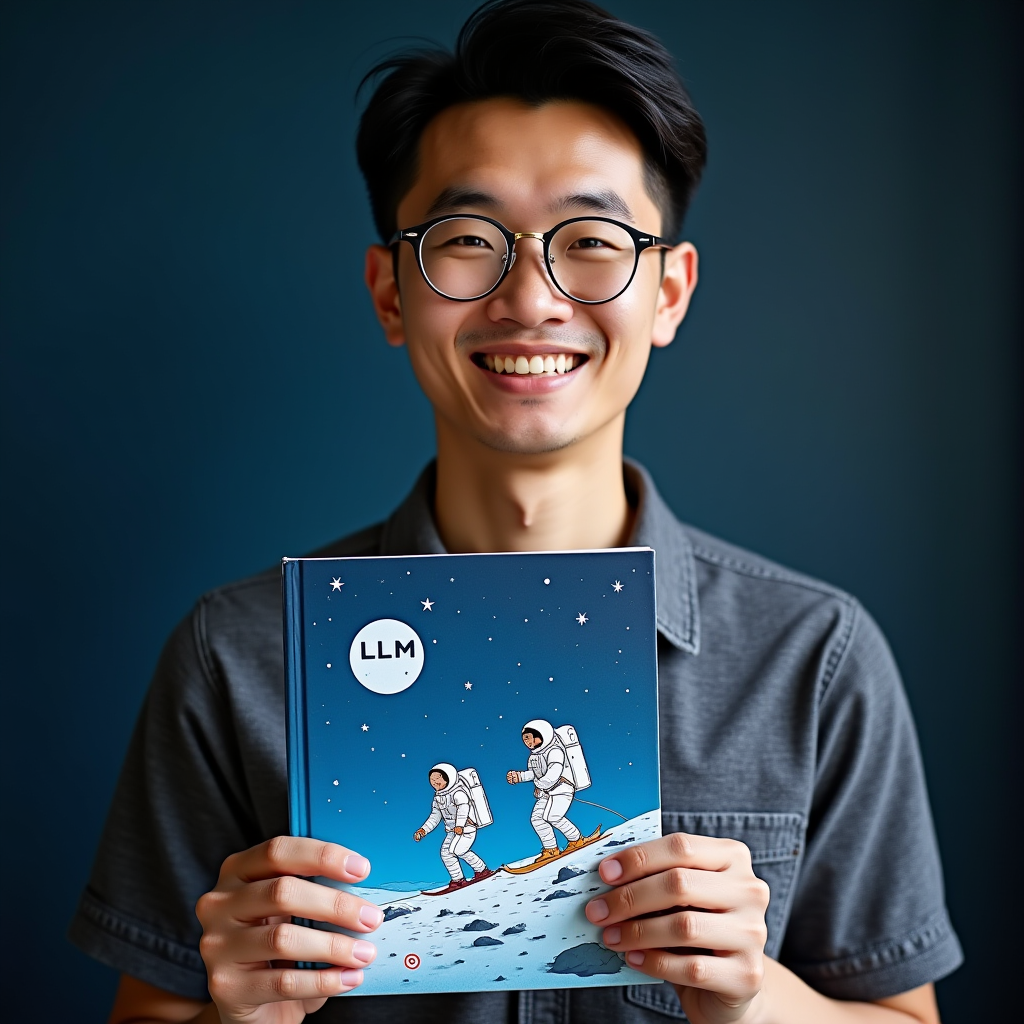

In [38]:
# Example of how to call the function
image = generate_image("A Handsome chinese man with glasses is holding a book named LLM , the cover of the book is a Astronauts skiing on the moon， the book cover is blue stars in the background. ")
display(image)

In [5]:
import torch  
from diffusers import FluxPipeline  
  
# 检查 GPU 是否可用  
if not torch.cuda.is_available():  
    raise ValueError("No GPU found. Please ensure you have a GPU available.")  
  
# 加载模型并将其移动到 GPU  
pipe = FluxPipeline.from_pretrained(  
    "black-forest-labs/FLUX.1-dev",  
    torch_dtype=torch.float16  # 或者使用 torch.float32  
).to("cuda")  
  
# 设置提示词  
prompt = "A cat holding a sign that says hello world"  
  
# 在 GPU 上创建生成器并设置种子  
generator = torch.Generator(device='cuda').manual_seed(0)  
  
# 使用自动混合精度进行推理  
with torch.cuda.amp.autocast(enabled=True):  
    image = pipe(  
        prompt,  
        height=1024,  
        width=1024,  
        guidance_scale=3.5,  
        num_inference_steps=50,  
        max_sequence_length=512,  
        generator=generator  
    ).images[0]  
  
# 保存结果  
image.save("flux-dev.png")  


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

ValueError: Cannot instantiate this tokenizer from a slow version. If it's based on sentencepiece, make sure you have sentencepiece installed.